In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import site
import numpy as np
import pandas as pd

(10.0, 14.1)

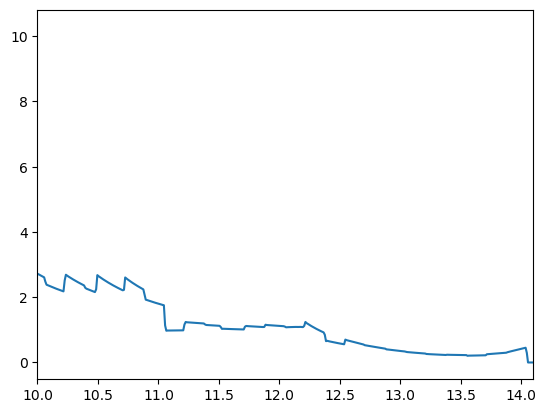

In [50]:
plt.plot(age_center_bins, hist)
plt.xlim(10, 14.1)

# Introduction

Similar to illustris_python, we install and load our module from a directory. 

In [2]:
# import h5py

# f = h5py.File('/mnt/ceph/users/agabrielpillai/camels_sam/CV/CV_3/hdf5/0_0_0/subvolume.hdf5', 'r')

In [3]:
# string = "{:<24s} {:<25s} {}"

# _ = [[print(f['Galprop'][key].attrs['Desc']) ]  
#      for key in f['Galprop'].keys()]

In [4]:
# string = "{:<24s} {:<25s} {}"

# _ = [[print(string.format(key, f['Galprop'][key].attrs['Units'], f['Galprop'][key].attrs['Desc'])) ]  
#      for key in f['Galprop'].keys()]

In [5]:
site.addsitedir('/mnt/home/agabrielpillai/github/') 
import scsample

First, we specify the basepath to the simulation.

In [6]:
basePath = '/mnt/ceph/users/agabrielpillai/camels_sam/CV/CV_3/hdf5'

The header will give us some basic information about the star formation histories and simulation. 

In [8]:
header = scsample.utility.load_header(basePath, [1, 0, 1], 'sfh')

header['h'], header['Omega_m'], header['SFH_tbins']

(0.6711,
 0.3,
 array([5.0000e-03, 1.5000e-02, 2.5000e-02, ..., 1.9975e+01, 1.9985e+01,
        1.9995e+01], dtype=float32))

We see `header['h']` and `header['Omega_m']` are important information for instantiating cosmologies through astropy ... 

## Linkprop

Let's see what info lives in the star formation history file. First, we have `linkprop`, which contains general information and linking data between the star formation histories and `galprop`. We can load `linkprop` for an entire subvolume while leaving the optional argument ``fields`` as None to see everything ... 

In [9]:
link_res = scsample.histcat.load_linkprop(basePath, [1, 0, 0])
link_res

{'LinkpropBirthHaloID': array([48838761, 49446534, 50052280, ..., 55765794, 56376151, 56960930],
       dtype=uint32),
 'LinkpropHaloIndex': array([     0,      1,      2, ..., 102592, 102593, 102594], dtype=uint32),
 'LinkpropRedshift': array([0.167174 , 0.152751 , 0.139173 , ..., 0.0233739, 0.0113166,
        0.       ], dtype=float32),
 'LinkpropRootHaloID': array([56639814, 56639814, 56639814, ..., 56960930, 56960930, 56960930],
       dtype=uint32),
 'LinkpropSnapNum': array([86, 87, 88, ..., 97, 98, 99], dtype=uint32)}

Most of this information is for internal purposes but serves as good validation if the crossmatching between `linkprop` / `histprop` and `galprop` is done correctly. 

## Histprop

In [11]:
subvolumes = scsample.utility.gen_subvolume_list(8)
subvolumes

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

In [12]:
sfh_res = scsample.histcat.load_histprop(basePath, [0, 0, 0])


In [13]:
snap_num = 99 

sfh_res_snap = scsample.histcat.load_snapshot_histprop(basePath, snap_num, subvolumes)
sfh_res_snap, sfh_res_snap['HistpropSFH'].shape

100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


({'HistpropSFH': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'HistpropZt': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)},
 (43287, 2000))

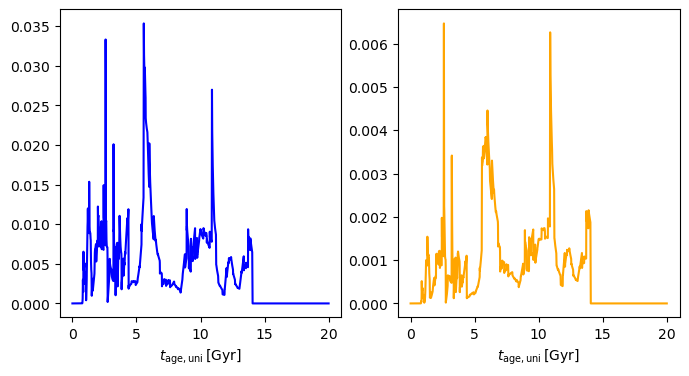

In [14]:
tbins = header['SFH_tbins']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

[axes[0].plot(tbins, sfh_res_snap['HistpropSFH'][i, :], c='blue', label='SFH', alpha=1) for i in range(1)]
[axes[1].plot(tbins, sfh_res_snap['HistpropZt'][i, :], c='orange', label='Zt', alpha=1) for i in range(1)]

# _ = [ax.legend() for ax in axes]

_ = [ax.set_xlabel(r'$t_{\rm age, uni} \, [{\rm Gyr}]$') for ax in axes]
# _ = [ax.set_yscale('log') for ax in axes]

## Crossmatching to galprop

In [16]:
galprop_res = scsample.histcat.crossmatch_galprop(basePath, [0, 0, 0]) #, galprop_fields=galprop_fields)
# galprop_res

Exception: Catalog does not have requested field [LinkproptoGalprop]!

In [17]:
link_res_snap = scsample.histcat.load_snapshot_linkprop(basePath, snap_num, subvolumes)
link_res_snap['LinkpropBirthHaloID']

100%|██████████| 8/8 [00:00<00:00, 153.04it/s]


array([56495026, 56495029, 56495032, ..., 52257384, 52257396, 53457348],
      dtype=uint32)

In [18]:
galprop_res_snap = scsample.histcat.crossmatch_snapshot_galprop(basePath, snap_num, subvolumes) #, galprop_fields=galprop_fields)
galprop_res_snap['GalpropBirthHaloID']

Exception: Catalog does not have requested field [LinkproptoGalprop_Snapshot]!

In [ ]:
f_rec = 0.43 


mstar = ilsam.groupcat.load_galprop(basePath, [0, 0, 0])['GalpropMstar']

fig, ax = plt.subplots(1, 1) 

ax.scatter(np.log10(sfh_res['HistpropSFH'].sum(axis=1) * 1e9 * (1 - f_rec)  ), 
            np.log10(1e9*galprop_res['GalpropMstar']), 
           s = 0.1)


ax.scatter(np.log10(sfh_res['HistpropSFH'].sum(axis=1) * 1e9  * (1 - f_rec) ), 
            np.log10(1e9*mstar[mstar * 1e9 >= 1e9]), 
           s = 0.1)

ax.plot([8, 12], [8, 12], ls='--', c='black') 
ax.set_xlim(8, 12)
ax.set_ylim(8, 12) 

ax.set_xlabel(r'$ \log_{10} \Sigma({\rm SFH}) \, [M_\odot] $')
ax.set_ylabel(r'$\log_{10} m_{*} \, [M_\odot]$')

In [ ]:
f_rec = 0.43 

fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 

ax.scatter(np.log10(sfh_res_snap['HistpropSFH'].sum(axis=1) * 1e9 * (1 - f_rec) ), 
            np.log10(1e9*galprop_res_snap['GalpropMstar']), 
           s = 0.1, alpha=0.1, c='black')

ax.plot([8, 12], [8, 12], ls='--', c='black') 
ax.set_xlim(7, 12)
ax.set_ylim(8.5, 12) 

ax.set_xlabel(r'$ \log_{10} m_{*, \rm SFH} = (1 - f_{\rm rec}) \Sigma({\rm SFH}) \, [M_\odot] $', fontsize=14)
ax.set_ylabel(r'$\log_{10} m_{*, \rm galprop} \, [M_\odot]$', fontsize=14)

# Interfacing SFHs with FSPS 

more to come ... 

# Interfacing SFHs with Synthesizer 

more to come ...